# Analyse simple Bayesian optimization

In [ ]:
import pickle

import torch
import numpy as np
import matplotlib.pyplot as plt

import seaborn as sns

In [2]:
with open('../scripts/simple_bo_results.pick', 'rb') as fo:
    d = pickle.load(fo)

In [3]:
d.keys()

dict_keys(['oracles', 'experiments'])

In [9]:
def compute_cumulative_min_for_batch(queries_in_time_order, num_batches, batch_size):
    queries = np.array([e.score for e in queries_in_time_order])
    queries_batched = queries.reshape(50, batch_size)
    min_per_query = queries_batched.min(axis=1)
    cumulative_min = np.minimum.accumulate(min_per_query)
    return cumulative_min
    

/scratch/jab255/anaconda3/envs/py37_bayesvs/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


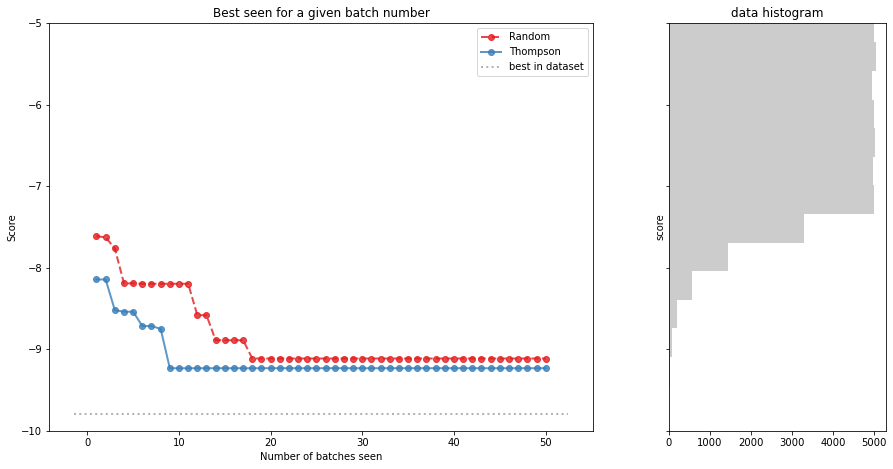

In [32]:
f, axarr = plt.subplots(1, 2, figsize=(15, 7.5), sharey=True, gridspec_kw={'width_ratios':[2.5,1]})


# Line plot
ax = axarr[0]
accumulated_mean_random = compute_cumulative_min_for_batch(d['experiments']['Random']['experiment_queriers'][-1].queries_in_time_order, 50, 100)
accumulated_mean_thompson = compute_cumulative_min_for_batch(d['experiments']['Thompson']['experiment_queriers'][-1].queries_in_time_order, 50, 100)

all_values = np.array(list(d['oracles']['gt']._properties.values()))
min_of_data = np.min(all_values)

batch_indices = np.arange(accumulated_mean_random.size) + 1

cols = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ax.plot(batch_indices, accumulated_mean_random, label='Random', color=cols[0], linestyle='--', lw=2, marker='o', alpha=0.8)
ax.plot(batch_indices, accumulated_mean_thompson, label='Thompson', color=cols[1], lw=2, linestyle='-', marker='o', alpha=0.8)
x_lim = ax.get_xlim()
ax.plot(x_lim, [min_of_data, min_of_data], ':', color='gray', lw=2, alpha=0.6, label='best in dataset')

ax.set_xlabel('Number of batches seen')
ax.set_ylabel('Score')
ax.legend()
ax.set_title('Best seen for a given batch number')
orig_ylim = ax.get_ylim()


# Histogram
ax = axarr[1]
sns.distplot(all_values, vertical=True, color='gray', ax=ax, kde=False)

ax.set_ylim([-10, -5])
ax.set_ylabel('score')
ax.set_title('data histogram')


plt.show()




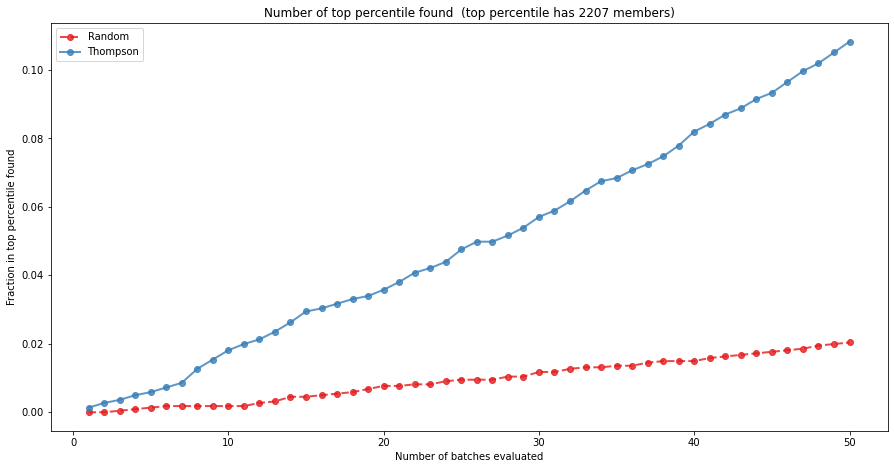

In [43]:
f, axarr = plt.subplots(figsize=(15, 7.5))

ax = axarr
all_smiles_scores_sorted = sorted(list(d['oracles']['gt']._properties.items()), key=lambda x: x[1])
top_one_percent = all_smiles_scores_sorted[:int(np.ceil(len(all_smiles_scores_sorted) / 100. ))]
top_one_percent_smiles_set = set([e[0] for e in top_one_percent])


def get_num_found_in_top_one_percent(queries_in_time_order, batch_size):
    all_smiles = [e.smiles for e in queries_in_time_order]
    #assert len(set(all_smiles)) == len(all_smiles), "picking same SMILES multiple times!"
    seen_smiles = set()
    all_smiles_new = []
    for s in all_smiles:
        if s in seen_smiles:
            s = 'seen so not double counting'
        seen_smiles.add(s)
        all_smiles_new.append(s)
    all_smiles =  all_smiles_new
    
    smiles_seen = np.array([e in top_one_percent_smiles_set for e in all_smiles], dtype=np.float32)
    number_seen = np.cumsum(smiles_seen)
    number_seen_at_end_of_batch = number_seen[batch_size-1::batch_size]
    return number_seen_at_end_of_batch / len(top_one_percent_smiles_set)


number_seen_random = get_num_found_in_top_one_percent(d['experiments']['Random']['experiment_queriers'][-1].queries_in_time_order, 100) 
number_seen_thompson = get_num_found_in_top_one_percent(d['experiments']['Thompson']['experiment_queriers'][-1].queries_in_time_order, 100)

batch_indcs = np.arange(number_seen_random.size) + 1


cols = ['#e41a1c','#377eb8','#4daf4a','#984ea3']
ax.plot(batch_indcs, number_seen_random, label='Random', color=cols[0], linestyle='--', lw=2, marker='o', alpha=0.8)
ax.plot(batch_indcs, number_seen_thompson, label='Thompson', color=cols[1], lw=2, linestyle='-', marker='o', alpha=0.8)

ax.set_ylabel(f'Fraction in top percentile found')
ax.set_title(f'Number of top percentile found  (top percentile has {len(top_one_percent_smiles_set)} members)')
ax.set_xlabel('Number of batches evaluated')
ax.legend()
plt.show()



In [35]:
number_seen_random

array([ 0.,  0.,  1.,  2.,  3.,  4.,  4.,  4.,  4.,  4.,  4.,  6.,  7.,
       10., 10., 11., 12., 13., 15., 17., 17., 18., 18., 20., 21., 21.,
       21., 23., 23., 26., 26., 28., 29., 29., 30., 30., 32., 33., 33.,
       33., 35., 36., 37., 38., 39., 40., 41., 43., 44., 45.],
      dtype=float32)

{'Random': {'experiment_queriers': [<bayes_vs.querier.QueriedHeap at 0x7f9519aa8ed0>,
   <bayes_vs.querier.QueriedHeap at 0x7f950ab6be50>]},
 'Thompson': {'experiment_queriers': [<bayes_vs.querier.QueriedHeap at 0x7f950a9434d0>,
   <bayes_vs.querier.QueriedHeap at 0x7f9503a7c1d0>]}}

[('C[C@H](C(=O)Nc1cc([N+](=O)[O-])ccc1Cl)N(C)C[C@@H]1CCC[C@@H]1O',
  -9.796726426560799),
 ('C[C@@H](NC[C@](C)(O)c1ccccc1)c1cn(-c2ccccc2)nn1', -9.74910737894175),
 ('CC[C@@H](O)[C@@H]1CCCCN1CC(=O)Nc1ccc(Br)c(C)c1', -9.74910737894175),
 ('C[C@H](Nc1cc(-n2cccn2)nc(N)n1)[C@H](c1ccccc1)N(C)C', -9.625297855132228),
 ('CC(C)N1C[C@@H](C)[C@H](NC(=O)C(=O)N2CCc3c2cccc3Cl)C1', -9.563393093227464),
 ('COC(=O)C[C@H]1CSCCN1Cc1cn(-c2cccc(C)c2)nc1C', -9.51815499798937),
 ('CCOC(=O)c1nn(-c2ccccc2)cc1CN1CC[C@@](C)(O)C1', -9.511012140846512),
 ('Clc1ccccc1-c1cc(CN2CCC[C@H]2Cn2cncn2)no1', -9.451488331322702),
 ('c1ncn(C[C@@H]2CCCN2Cc2cc(-c3ccccc3)cs2)n1', -9.449107378941749),
 ('O=C(NCCCn1ccc2ccccc21)[C@@H](C1CC1)N1CCCC1', -9.43005975989413)]

4.476089389782212